# This notebook is to compare region calling results from peak calling results.

## What is region calling?


In [1]:
region_path='/home/hsher/YTHDF2/region_call/'
peak_path='/home/hsher/YTHDF2/intersecting_bed/'
peakdir='/home/hsher/YTHDF2/raw_beds/'

condition_dict = {'YTHDF2':
                  {'lib': ['m1', 'm2', 'm3'],
                  'fast':['m4', 'm5', 'm6']
                 },
                  'm6A':
                {'lib': ['m7', 'm8', 'm9'],
                  'fast':['m10', 'm11', 'm12']
                 }}
from pybedtools import BedTool
order = ['intron', 'exon', 'five_prime_UTR', 'three_prime_UTR']

In [2]:
coord = BedTool('/home/hsher/gencode_coords/gencode.vM25.combine.sorted.gff3')
from collections import Counter
def read_condition_region(cond, rbp):
    smpl = condition_dict[rbp][cond]
    bedlist= []
    for s in smpl:
        fname = '{}zt2_liver_{}_eCLIP.{}_IP.umi.r1.fq.genome-mappedSoSo.rmDupSo.bed'.format(region_path, rbp, s)
        bedlist.append(BedTool(fname))
    return bedlist
def read_condition_peaks(rbp, condition):
    three_peaks = []
    for lib in condition_dict[rbp][condition]: #['m1', 'm2', 'm3']
        fname = 'zt2_liver_{}_eCLIP.{}_IP.umi.r1.fq.genome-mappedSoSo.rmDupSo.peakClusters.normed.compressed.sort.bed'.format(rbp, lib)
        three_peaks.append(BedTool(peakdir+fname))
    return three_peaks

def count_region_type(bed):
    annot = coord.intersect(bed, s=True, u = True)
    type_feature = [a[2] for a in annot]
    c = Counter(type_feature)
    
    return c

def count_region(bed):
    ''' not by overalapping the coord since it has problems'''

# feature type distribution from individual peaks

In [3]:
# now count region type of individual peaks
import pandas as pd



dicts = []
for rbp in ['YTHDF2', 'm6A']:
    for cond in ['lib', 'fast']:
        smpl = condition_dict[rbp][cond]
        beds = read_condition_peaks(rbp, cond)
        
        for b,s in zip(beds, smpl):
            count = count_region_type(b)
            result = dict(count)
            result['rbp'] = rbp
            result['sample'] = s
            result['condition'] = cond
            dicts.append(result)

peak_count = pd.DataFrame(dicts)
peak_count.columns = [c if c != 'transcript' else 'intron' for c in peak_count.columns.tolist()]

In [4]:
peak_count

,intron,exon,five_prime_UTR,three_prime_UTR,rbp,sample,condition
0,3931,9267,486,615,YTHDF2,m1,lib
1,9745,23794,1429,1623,YTHDF2,m2,lib
2,10313,24858,1754,2111,YTHDF2,m3,lib
3,8531,21484,1405,1713,YTHDF2,m4,fast
4,11176,26260,1504,1818,YTHDF2,m5,fast
5,15062,33367,1974,2438,YTHDF2,m6,fast
6,30193,80218,10556,10418,m6A,m7,lib
7,27739,71385,9129,10631,m6A,m8,lib
8,8683,13274,2398,3343,m6A,m9,lib
9,24230,67668,9844,9784,m6A,m10,fast


Text(0.5, 1.0, 'Individual peak type distribution')

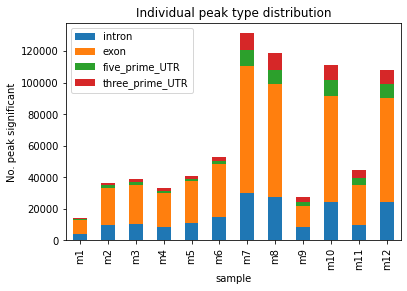

In [5]:
import matplotlib.pyplot as plt
peak_count.set_index('sample').fillna(0).plot.bar(stacked = True)
plt.ylabel('No. peak significant')
plt.title('Individual peak type distribution')

In [6]:
def get_comp(count_df):
    comp = count_df.set_index('sample').iloc[:, :4].fillna(0)
    comp = comp.div(comp.sum(axis = 1), axis = 0)
    return comp

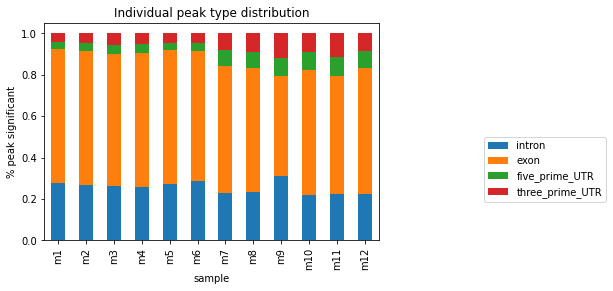

In [7]:
get_comp(peak_count).plot.bar(stacked = True)
plt.ylabel('% peak significant')
plt.title('Individual peak type distribution')
plt.legend(bbox_to_anchor=(1.3,0.5))

# region type distribution, is it the same as peaks?

In [8]:
dicts = []
for rbp in ['YTHDF2', 'm6A']:
    for cond in ['lib', 'fast']:
        smpl = condition_dict[rbp][cond]
        beds = read_condition_region(cond, rbp)
        
        for b,s in zip(beds, smpl):
            count = count_region_type(b)
            result = dict(count)
            result['rbp'] = rbp
            result['sample'] = s
            result['condition'] = cond
            dicts.append(result)

region_count = pd.DataFrame(dicts)
region_count.columns = [c if c != 'transcript' else 'intron' for c in region_count.columns.tolist()]

Text(0.5, 1.0, 'Individual region type distribution')

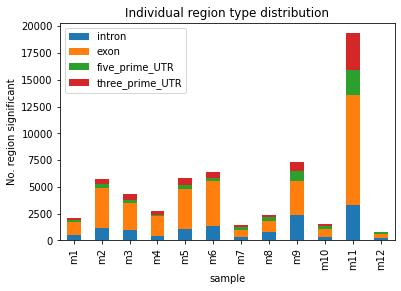

In [9]:
region_count.set_index('sample').fillna(0)[order].plot.bar(stacked = True)
plt.ylabel('No. region significant')
plt.title('Individual region type distribution')

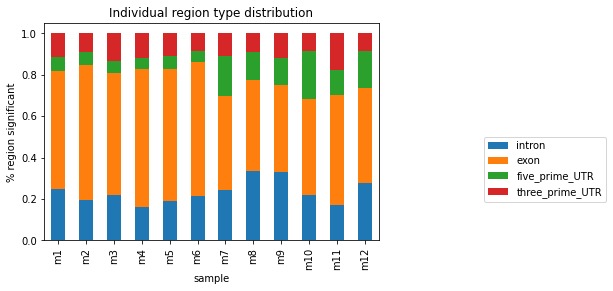

In [10]:
get_comp(region_count)[order].plot.bar(stacked = True)
plt.ylabel('% region significant')
plt.title('Individual region type distribution')
plt.legend(bbox_to_anchor=(1.3,0.5))

# Reproducibility between reps!

In [15]:
from matplotlib_venn import venn3, venn2
types = ['UTR3', 'UTR5', 'exon', 'intron']

def region_id_extraction(beds):
    
    all_ids = []
    for bed in beds:
        
        utr3s = [interval[3].split(':')[1] for interval in bed if 'UTR3' in interval[3]]
        utr5s = [interval[3].split(':')[1] for interval in bed if 'UTR5' in interval[3]]
        exons = [interval[3].split(':')[1] for interval in bed if 'exon' in interval[3]]
        introns = [interval[3] for interval in bed if 'exon'  not in interval[3] and 'UTR' not in interval[3]]
        
        id_dict = dict(zip(types, [utr3s, utr5s, exons, introns]))
        all_ids.append(id_dict)
    return all_ids

def peak_id_extraction(beds):
    all_ids = []
    for bed in beds:
        
    
        annot = coord.intersect(bed, s=True, u = True)
        exons = [a.attrs['transcript_id'] for a in annot if a[2] == 'exon']
        utr5s = [a.attrs['transcript_id'] for a in annot if a[2] == 'five_prime_UTR']
        utr3s = [a.attrs['transcript_id'] for a in annot if a[2] == 'three_prime_UTR']
        introns = [a.attrs['transcript_id'] for a in annot if a[2] != 'exon' and 'prime_utr' not in a[2]]
        
        id_dict = dict(zip(types, [utr3s, utr5s, exons, introns]))
        all_ids.append(id_dict)
    return all_ids
def plot_intersect(all_ids, labels, title):
    f, ax = plt.subplots(1,len(types), figsize = (12,3))
    i = 0
    for feat in types:
        sets = [set(i[feat]) for i in all_ids]
        venn3(sets, set_labels = tuple(labels), ax = ax[i])
        ax[i].set_title(feat)
        i+=1
    plt.suptitle(title)
    
def compare_region_peak(peaks, regions, labels, title):
    f, ax = plt.subplots(3,len(types), figsize = (12,3))
    i = 0
    
    for p,r in zip(peaks, regions):
        j = 0
        for feat in types:
            sets = [set(i[feat]) for i in [p,r]]
            venn2(sets, set_labels = tuple(labels), ax = ax[i,j])
            ax[i,j].set_title(feat)
            j+=1
        i+= 1
    plt.suptitle(title)
        

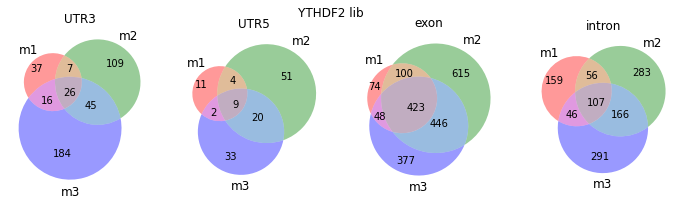

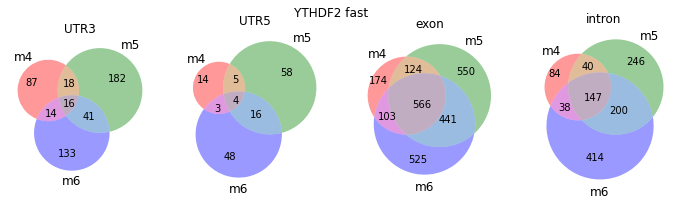

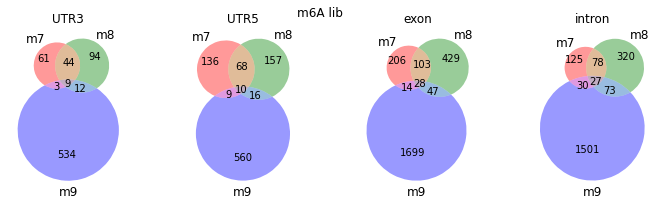

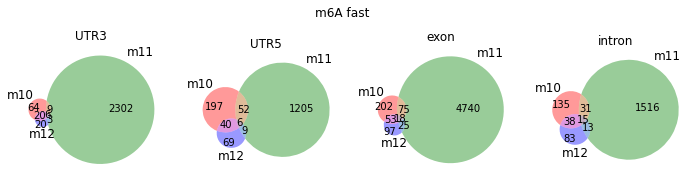

In [12]:
for rbp in ['YTHDF2', 'm6A']:
    for cond in ['lib', 'fast']:
        smpl = condition_dict[rbp][cond]
        beds = read_condition_region(cond, rbp)

        s = region_id_extraction(beds)
        plot_intersect(s, smpl, '{} {}'.format(rbp, cond))

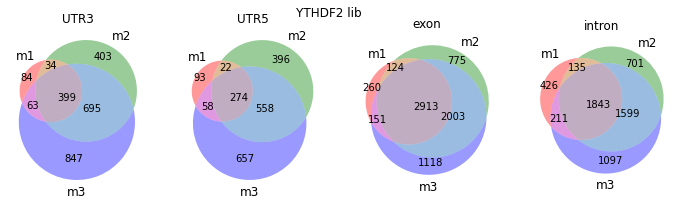

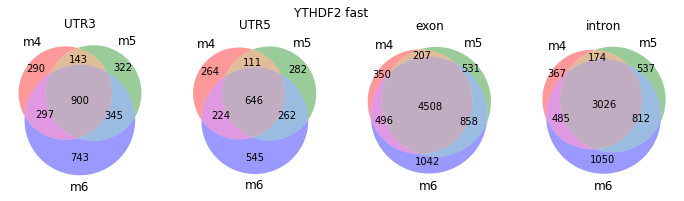

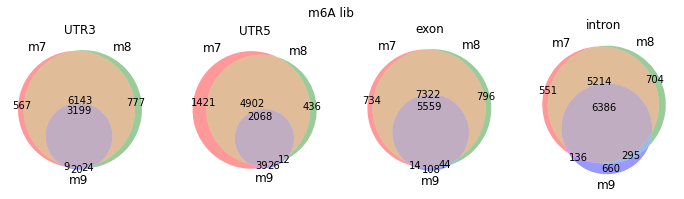

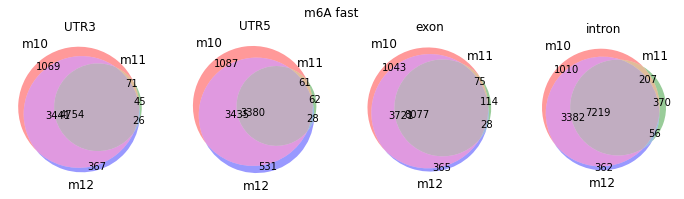

In [13]:

for rbp in ['YTHDF2', 'm6A']:
    for cond in ['lib', 'fast']:
        smpl = condition_dict[rbp][cond]
        beds = read_condition_peaks(rbp, cond)

        s = peak_id_extraction(beds)
        plot_intersect(s, smpl, '{} {}'.format(rbp, cond))

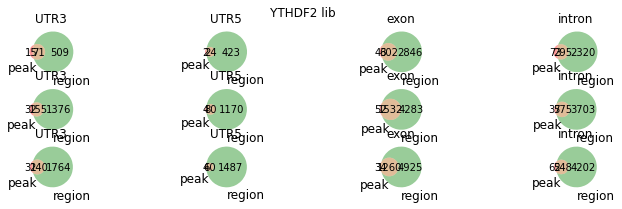

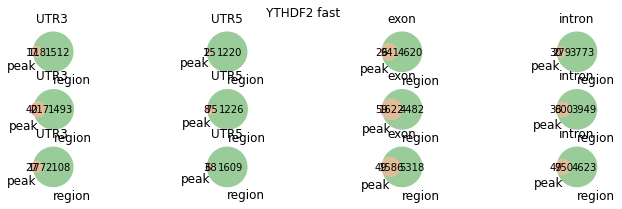

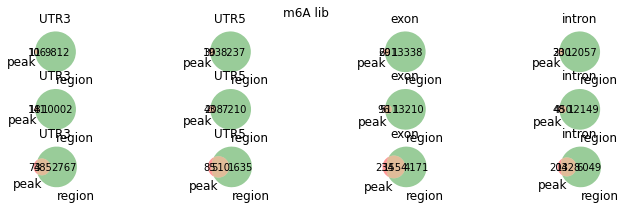

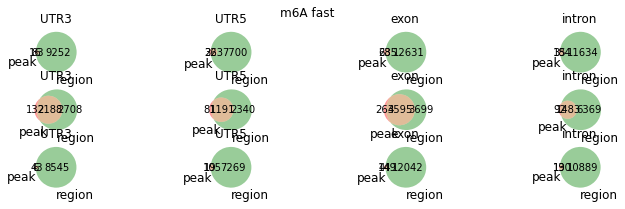

In [16]:
for rbp in ['YTHDF2', 'm6A']:
    for cond in ['lib', 'fast']:
        smpl = condition_dict[rbp][cond]
        peaks = read_condition_peaks(rbp, cond)
        regions = read_condition_region(cond, rbp)
    
        region_id = region_id_extraction(regions)
        peak_id = peak_id_extraction(peaks)

        compare_region_peak(region_id, peak_id, ['peak', 'region'], '{} {}'.format(rbp, cond))

In [ ]:
region_id